# EDA

In [1]:
import os
mao_sentences = []
for root, dirs, files in os.walk("../mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().replace('?','.').replace('!','.').replace('\n','.')
                sentences = sentences.split(".")   #. denotes end of sentence
            mao_sentences.extend(sentences)
            
print(len(mao_sentences))
print(mao_sentences[0])

../mao/REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
../mao/WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
../mao/ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
../mao/ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
../mao/A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
../mao/BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
1702
THE IMPORTANCE OF THE PEASANT PROBLEM


In [2]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

,Sentence
0,THE IMPORTANCE OF THE PEASANT PROBLEM
1,During my recent visit to Hunan [1] I made a f...
2,In the thirty-two days from January 4 to Febr...
3,Many of the hows and whys of the peasant move...
4,I saw and heard of many strange things of whi...


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

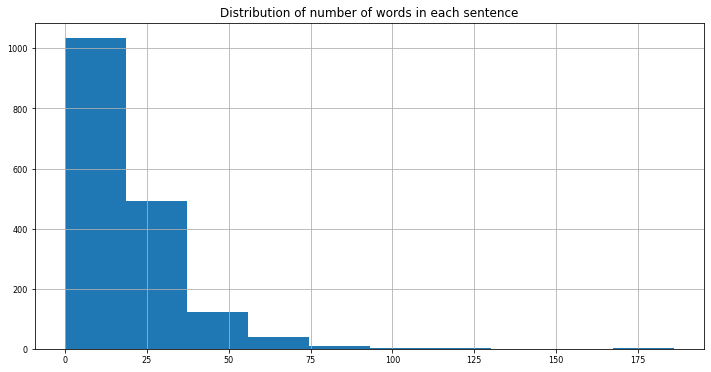

In [3]:
mao_df['NumWords'] = mao_df['Sentence'].apply(lambda x: len(x.split()))
mao_df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

Let's do some cleaning operations like turning all words to lowercase, remove punctuation and non-ASCII characters which are irrelevant for modeling topics.

In [4]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df.head()
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

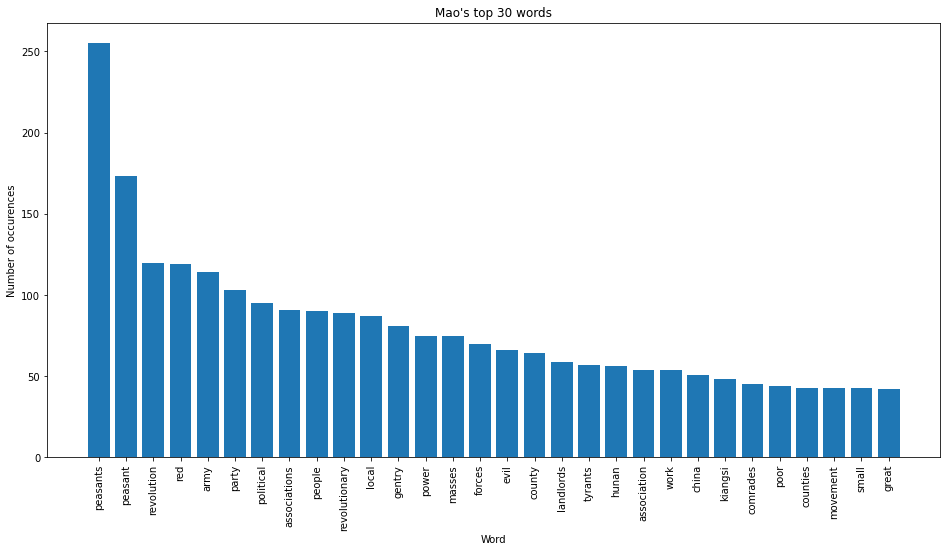

In [5]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(mao_df['Sentence2'], 30):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 30 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [6]:
mao_df.head()

,Sentence,NumWords,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,saw and heard many strange things which had hi...


Remove short sentence

In [7]:
mao_df = mao_df[mao_df.NumWords>0]
short_sentence = mao_df[mao_df.NumWords<5]
short_sentence

,Sentence,NumWords,Sentence2
14,There are three alternatives,4,there are three alternatives
21,GET ORGANIZED,2,get organized
53,"""Here's ten yuan",3,here ten yuan
57,"""Ugh",1,ugh
59,""" the peasants reply",4,the peasants reply
...,...,...,...
1655,Not in the least,4,not the least
1659,"No, nothing",2,nothing
1660,His bastions of iron,4,his bastions iron
1661,They all crumbled,3,they all crumbled


In [8]:
mao_df = mao_df[mao_df.NumWords>=5]
mao_df = mao_df.reset_index(drop=True)
mao_df

,Sentence,NumWords,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,saw and heard many strange things which had hi...
...,...,...,...
1167,All revolutionary cadres have a tremendous re...,7,all revolutionary cadres have tremendous respo...
1168,After this congress we must adopt effective m...,30,after this congress must adopt effective measu...
1169,We must create thousands of townships like Ch...,14,must create thousands townships like changkang...
1170,They will be our strongholds,5,they will our strongholds


# Sentence Embedding

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('stsb-roberta-large')

In [10]:
sentence_embeddings = model.encode(mao_df.Sentence2)
sentence_embeddings.shape

(1172, 1024)

# Kmeans

Try to find the best k, let us use `Silhouette Coefficient`

Silhouette Coefficient    
https://en.wikipedia.org/wiki/Silhouette_(clustering)   

-1<=Si<=1   
The clusting performance is better when the Silhouette Coefficient is close to 1

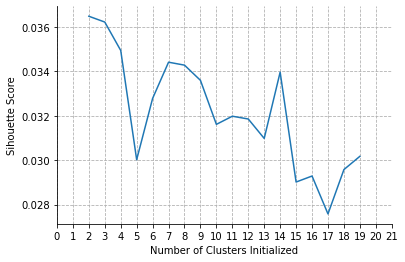

In [11]:
from sklearn import metrics
from sklearn.cluster import KMeans

scores = []
for k in range(2,20):
    labels = KMeans(n_clusters=k).fit(sentence_embeddings).labels_
    score = metrics.silhouette_score(sentence_embeddings, labels)
    scores.append(score)

plt.plot(list(range(2,20)),scores)
plt.xticks(range(0,22,1)) 
plt.grid(linestyle='--')
plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Sihouette Score")
sns.despine()

## 7 cluster Kmeans

In [12]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=7, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(sentence_embeddings)
df = pd.DataFrame({'mao': mao_df.Sentence, 'sentence2':mao_df.Sentence2, 'topic_cluster': y_km })

In [13]:
df.head()

,mao,sentence2,topic_cluster
0,THE IMPORTANCE OF THE PEASANT PROBLEM,the importance the peasant problem,4
1,During my recent visit to Hunan [1] I made a f...,during recent visit hunan made first hand inve...,1
2,In the thirty-two days from January 4 to Febr...,the thirty two days from january february call...,4
3,Many of the hows and whys of the peasant move...,many the hows and whys the peasant movement we...,1
4,I saw and heard of many strange things of whi...,saw and heard many strange things which had hi...,0


In [14]:
df.loc[df['topic_cluster'] == 0].head()

,mao,sentence2,topic_cluster
4,I saw and heard of many strange things of whi...,saw and heard many strange things which had hi...,0
15,"To trail behind them, gesticulating and criti...",trail behind them gesticulating and criticizing,0
29,DOWN WITH THE LOCAL TYRANTS AND EVIL GENTRY,down with the local tyrants and evil gentry,0
31,The main targets of attack by the peasants are...,the main targets attack the peasants are the l...,0
39,Those who are outside the associations can on...,those who are outside the associations can onl...,0


In [15]:
df.loc[df['topic_cluster'] == 1].head()

,mao,sentence2,topic_cluster
1,During my recent visit to Hunan [1] I made a f...,during recent visit hunan made first hand inve...,1
3,Many of the hows and whys of the peasant move...,many the hows and whys the peasant movement we...,1
20,"In this period, January to June was a time of...",this period january june was time underground ...,1
41,In the face of the peasant associations' powe...,the face the peasant associations power and pr...,1
47,"In the Ching Dynasty, the household census com...",the ching dynasty the household census compile...,1


In [16]:
df.loc[df['topic_cluster'] == 2].head()

,mao,sentence2,topic_cluster
5,I believe the same is true of many other plac...,believe the same true many other places too,2
11,They will smash all the trammels that bind th...,they will smash all the trammels that bind the...,2
14,To march at their head and lead them,march their head and lead them,2
16,Or to stand in their way and oppose them,stand their way and oppose them,2
17,"Every Chinese is free to choose, but events w...",every chinese free choose but events will forc...,2


In [17]:
df.loc[df['topic_cluster'] == 3].head()

,mao,sentence2,topic_cluster
6,All talk directed against the peasant movemen...,all talk directed against the peasant movement...,3
7,All the wrong measures taken by the revolutio...,all the wrong measures taken the revolutionary...,3
12,"They will sweep all the imperialists, warlord...",they will sweep all the imperialists warlords ...,3
33,"As a result, the privileges which the feudal ...",result the privileges which the feudal landlor...,3
43,Who wants your filthy money,who wants your filthy money,3


In [18]:
df.loc[df['topic_cluster'] == 4].head()

,mao,sentence2,topic_cluster
0,THE IMPORTANCE OF THE PEASANT PROBLEM,the importance the peasant problem,4
2,In the thirty-two days from January 4 to Febr...,the thirty two days from january february call...,4
9,For the present upsurge of the peasant moveme...,for the present upsurge the peasant movement c...,4
18,The development of the peasant movement in Hun...,the development the peasant movement hunan may...,4
22,"Since its members served as guides, scouts an...",since its members served guides scouts and car...,4


In [19]:
df.loc[df['topic_cluster'] == 5].head()

,mao,sentence2,topic_cluster
13,Every revolutionary party and every revolutio...,every revolutionary party and every revolution...,5
21,"During this period, the membership of the pea...",during this period the membership the peasant ...,5
40,"The local tyrants, evil gentry and lawless la...",the local tyrants evil gentry and lawless land...,5
48,In some places the peasants now use this meth...,some places the peasants now use this method s...,5
50,"Afraid of being entered in the other register,...",afraid being entered the other register such p...,5


In [20]:
df.loc[df['topic_cluster'] == 6].head()

,mao,sentence2,topic_cluster
8,Only thus can the future of the revolution be...,only thus can the future the revolution benefited,6
10,"In a very short time, in China's central, sou...",very short time china central southern and nor...,6
32,In force and momentum the attack is tempestuo...,force and momentum the attack tempestuous thos...,6
67,"Sun Yat-sen wanted, but failed, to accomplish...",sun yat sen wanted but failed accomplish the f...,6
78,The Revolution of 1911 [3] did not bring abou...,the revolution 111 did not bring about this ch...,6


In [21]:
centers = km.cluster_centers_
centers

array([[-0.30953214,  0.6305128 ,  0.32809758, ...,  0.27771795,
        -0.7601069 ,  0.6205398 ],
       [ 0.10599335,  0.34588677, -0.1222178 , ...,  0.54810643,
        -1.3297417 ,  0.29887426],
       [-0.12595537,  0.14595091, -0.06924996, ...,  0.27791902,
        -0.7823045 ,  0.54073364],
       ...,
       [-0.06784982,  0.34416237, -0.10358737, ...,  0.96032333,
        -0.90393364,  0.54917824],
       [-0.10502759,  0.02465358, -0.22885872, ...,  0.3169937 ,
        -0.14310682,  0.47161007],
       [ 0.20314845,  0.7646339 ,  0.06447813, ...,  0.86047673,
        -0.79031605,  0.37310952]], dtype=float32)

Select a sentence which is cloest to each group center

In [22]:
def select_center_sentence(group_id):
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = sentence_embeddings[df['topic_cluster'] == group_id]
    print('there are %d sentences in group %d'%(len(group_sentence_embeddings),group_id))
    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    df_group = df.loc[df['topic_cluster'] == group_id]
    df_group = df_group.reset_index(drop=True)
    return df_group.mao[min_index]

In [23]:
group0_belief = select_center_sentence(group_id = 0)
group0_belief

there are 179 sentences in group 0


'" This opinion comes to the same thing as what the right-wingers are saying; according to both it is all right to have a peasant movement (the movement is already in being and no one dare say otherwise), but they say that the people running it are no good and they particularly hate those in charge of the associations at the lower levels, calling them "riffraff"'

In [24]:
group1_belief = select_center_sentence(group_id = 1)
group1_belief

there are 159 sentences in group 1


' Again, when we captured Yunghsin for the third time, we once more divided our forces by dispatching the 28th Regiment to the border of Anfu County, the 29th to Lienhua, and the 31st to the border of Kian County'

In [25]:
group2_belief = select_center_sentence(group_id = 2)
group2_belief

there are 196 sentences in group 2


' It should be done on the following lines:'

In [26]:
group3_belief = select_center_sentence(group_id = 3)
group3_belief

there are 146 sentences in group 3


' Because of the growth in government taxation, the rise in rent and interest demanded by the landlords and the daily spread of the disasters of war, there are famine and banditry everywhere and the peasant masses and the urban poor can hardly keep alive'

In [27]:
group4_belief = select_center_sentence(group_id = 4)
group4_belief

there are 180 sentences in group 4


'ALL POWER TO THE PEASANT ASSOCIATIONS'

In [28]:
group5_belief = select_center_sentence(group_id = 5)
group5_belief

there are 135 sentences in group 5


' It was necessary to forbid malicious criticism of the peasant associations'

In [29]:
group6_belief = select_center_sentence(group_id = 6)
group6_belief

there are 177 sentences in group 6


' The prolonged splits and wars within the White regime provide a condition for the emergence and persistence of one or more small Red areas under the leadership of the Communist Party amidst the encirclement of the White regime'

# Filter meaningless sentences

In [30]:
group2 = df.loc[df['topic_cluster'] == 2]
group2

,mao,sentence2,topic_cluster
5,I believe the same is true of many other plac...,believe the same true many other places too,2
11,They will smash all the trammels that bind th...,they will smash all the trammels that bind the...,2
14,To march at their head and lead them,march their head and lead them,2
16,Or to stand in their way and oppose them,stand their way and oppose them,2
17,"Every Chinese is free to choose, but events w...",every chinese free choose but events will forc...,2
...,...,...,...
1154,"If our task is to cross a river, we cannot cr...",our task cross river cannot cross without brid...,2
1156,"Unless the problem of method is solved, talk ...",unless the problem method solved talk about th...,2
1167,All revolutionary cadres have a tremendous re...,all revolutionary cadres have tremendous respo...,2
1168,After this congress we must adopt effective m...,after this congress must adopt effective measu...,2


In [31]:
text = 'it should be done on the following lines:'

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

In [33]:
word_tokens = word_tokenize(text) 

filtered_sentence = [] 

for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w)

print("Original Sentence:\n")
print(" ".join(word_tokens)) 

print("\n\nFiltered Sentence:\n")
print(" ".join(filtered_sentence)) 

Original Sentence:

it should be done on the following lines :


Filtered Sentence:

done following lines :


In [34]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

nlp = English()
my_doc = nlp(text)

token_list = []
for token in my_doc:
    token_list.append(token.text)

filtered_sentence =[] 

for word in token_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
        filtered_sentence.append(word) 
print(token_list)
print(filtered_sentence)  

['it', 'should', 'be', 'done', 'on', 'the', 'following', 'lines', ':']
['following', 'lines', ':']


In [35]:
from gensim.parsing.preprocessing import remove_stopwords

# pass the sentence in the remove_stopwords function
result = remove_stopwords(text)

print('Filtered Sentence:')
print(result)

Filtered Sentence:
following lines:


Try to find difference between sentences

In [36]:
examples = group2.sentence2[:20]
examples

5            believe the same true many other places too
11     they will smash all the trammels that bind the...
14                        march their head and lead them
16                       stand their way and oppose them
17     every chinese free choose but events will forc...
19     the first from january september last year was...
23     the second period from last october january th...
46     committeeman from the provincial capital pleas...
49      they say put their names down the other register
54     matter what their identity all admit that the ...
59               under the impact the views the terrible
62     short nobody could altogether deny the word te...
68     this marvelous feat never before achieved not ...
79     this change now taking place and important fac...
81                            the question going too far
83               this the opinion the middle the roaders
84                         but what the actual situation
94     this what some people ca

In [37]:
for sentence in examples:
    print('Original sentence:')
    print(sentence)
    print('Filtered Sentence:')
    print(remove_stopwords(sentence))
    print()

Original sentence:
believe the same true many other places too
Filtered Sentence:
believe true places

Original sentence:
they will smash all the trammels that bind them and rush forward along the road liberation
Filtered Sentence:
smash trammels bind rush forward road liberation

Original sentence:
march their head and lead them
Filtered Sentence:
march head lead

Original sentence:
stand their way and oppose them
Filtered Sentence:
stand way oppose

Original sentence:
every chinese free choose but events will force you make the choice quickly
Filtered Sentence:
chinese free choose events force choice quickly

Original sentence:
the first from january september last year was one organization
Filtered Sentence:
january september year organization

Original sentence:
the second period from last october january this year was one revolutionary action
Filtered Sentence:
second period october january year revolutionary action

Original sentence:
committeeman from the provincial capital plea

In [40]:
group2['sentence3'] = group2['sentence2'].apply(lambda x: remove_stopwords(x))
group2.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,mao,sentence2,topic_cluster,sentence3
5,I believe the same is true of many other plac...,believe the same true many other places too,2,believe true places
11,They will smash all the trammels that bind th...,they will smash all the trammels that bind the...,2,smash trammels bind rush forward road liberation
14,To march at their head and lead them,march their head and lead them,2,march head lead
16,Or to stand in their way and oppose them,stand their way and oppose them,2,stand way oppose
17,"Every Chinese is free to choose, but events w...",every chinese free choose but events will forc...,2,chinese free choose events force choice quickly


In [55]:
from nltk import word_tokenize 
from nltk.util import ngrams
from collections import Counter

Create a word list

In [69]:
words = []
for sentence in group2.sentence3:
    for word in sentence.split():
        words.append(word)
words[:20]

['believe',
 'true',
 'places',
 'smash',
 'trammels',
 'bind',
 'rush',
 'forward',
 'road',
 'liberation',
 'march',
 'head',
 'lead',
 'stand',
 'way',
 'oppose',
 'chinese',
 'free',
 'choose',
 'events']

In [71]:
len(words)

1086

Caculate the most common bigrams, I chose top 10% bigrams

In [74]:
ngram_counts = Counter(ngrams(words, 2))
bigrams = ngram_counts.most_common((int) (len(words)/10))

In [75]:
len(bigrams)

108

Convert bigrams to string and store in a list

In [96]:
strings = []
for bigram in bigrams:
    strings.append(bigram[0][0] + ' ' + bigram[0][1])

In [97]:
strings

['people principles',
 'methods correction',
 'correction follows',
 'central committee',
 'going far',
 'manifests follows',
 'rank file',
 'bodies party',
 'higher bodies',
 'lower bodies',
 'party organization',
 'second period',
 'revolutionary action',
 'proper limits',
 'general direction',
 'tall paper',
 'paper hat',
 'joint council',
 'border area',
 'industrial proletariat',
 'leading bodies',
 'party rank',
 'methods carrying',
 'disregard organizational',
 'organizational discipline',
 'minority submit',
 'submit majority',
 'petty bourgeois',
 'method correction',
 'letter central',
 'masses want',
 'want win',
 'methods work',
 'problem methods',
 'believe true',
 'true places',
 'places smash',
 'smash trammels',
 'trammels bind',
 'bind rush',
 'rush forward',
 'forward road',
 'road liberation',
 'liberation march',
 'march head',
 'head lead',
 'lead stand',
 'stand way',
 'way oppose',
 'oppose chinese',
 'chinese free',
 'free choose',
 'choose events',
 'events for

In [85]:
group2 = group2.reset_index(drop=True)
group2.head()

,mao,sentence2,topic_cluster,sentence3
0,I believe the same is true of many other plac...,believe the same true many other places too,2,believe true places
1,They will smash all the trammels that bind th...,they will smash all the trammels that bind the...,2,smash trammels bind rush forward road liberation
2,To march at their head and lead them,march their head and lead them,2,march head lead
3,Or to stand in their way and oppose them,stand their way and oppose them,2,stand way oppose
4,"Every Chinese is free to choose, but events w...",every chinese free choose but events will forc...,2,chinese free choose events force choice quickly


In [93]:
group2_filter = pd.DataFrame(columns = ['mao','sentence2','topic_cluster','sentence3'])

Pick rows which contains top 10% bigrams

In [98]:
for index, row in group2.iterrows():
    for bigram in strings:
        if bigram in row.sentence3:
            group2_filter = group2_filter.append(group2.iloc[index,:])
            break

In [99]:
group2_filter

,mao,sentence2,topic_cluster,sentence3
0,I believe the same is true of many other plac...,believe the same true many other places too,2,believe true places
1,They will smash all the trammels that bind th...,they will smash all the trammels that bind the...,2,smash trammels bind rush forward road liberation
2,To march at their head and lead them,march their head and lead them,2,march head lead
3,Or to stand in their way and oppose them,stand their way and oppose them,2,stand way oppose
4,"Every Chinese is free to choose, but events w...",every chinese free choose but events will forc...,2,chinese free choose events force choice quickly
...,...,...,...,...
166,"If we want to win, we must do a great deal more",want win must great deal more,2,want win great deal
183,Do we want to win the support of the masses,want win the support the masses,2,want win support masses
188,The second question concerns our methods of work,the second question concerns our methods work,2,second question concerns methods work
189,"In this respect, we are faced with the seriou...",this respect are faced with the serious proble...,2,respect faced problem methods work


In [105]:
group2_filter = group2_filter.reset_index(drop=True)

Select the vector which is cloest to group center

In [107]:
def select_center_sentence(group_id):
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = model.encode(group2_filter.sentence3)

    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    return group2_filter.mao[min_index]

In [108]:
print(select_center_sentence(2))

 Since then, however, the appraisals and directives of the Central Committee have in the main been correct


write above process into a function, and apply it to other groups

In [121]:
def bigram_based_filter(group_id):
    group = df.loc[df['topic_cluster'] == group_id]
    group['sentence3'] = group['sentence2'].apply(lambda x: remove_stopwords(x))
    words = []
    
    #get word list
    for sentence in group.sentence3:
        for word in sentence.split():
            words.append(word)
            
    # get 10% most common bigrams
    ngram_counts = Counter(ngrams(words, 2))
    bigrams = ngram_counts.most_common((int) (len(words)/10))
    
    # convert bigrams into a string and store in a list
    strings = []
    for bigram in bigrams:
        strings.append(bigram[0][0] + ' ' + bigram[0][1])
        
    group = group.reset_index(drop=True)
    group_filter = pd.DataFrame(columns = ['mao','sentence2','topic_cluster','sentence3'])
    
    for index, row in group.iterrows():
        for bigram in strings:
            if bigram in row.sentence3:
                group_filter = group_filter.append(group.iloc[index,:])
                break
    
    group_filter = group_filter.reset_index(drop=True)
    
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = model.encode(group_filter.sentence3)

    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    return group_filter.mao[min_index]

In [122]:
bigram_based_filter(0)

' The most one can call these is "an unhealthy minority", and we must not echo the local tyrants and evil gentry in undiscriminatingly condemning them as "riffraff"'

'" This opinion comes to the same thing as what the right-wingers are saying; according to both it is all right to have a peasant movement (the movement is already in being and no one dare say otherwise), but they say that the people running it are no good and they particularly hate those in charge of the associations at the lower levels, calling them "riffraff"'

In [123]:
bigram_based_filter(1)

'That county government cannot be clean until the peasants rise up was proved some time ago in Haifeng, Kwangtung Province'

' Again, when we captured Yunghsin for the third time, we once more divided our forces by dispatching the 28th Regiment to the border of Anfu County, the 29th to Lienhua, and the 31st to the border of Kian County'

In [124]:
bigram_based_filter(2)

' Since then, however, the appraisals and directives of the Central Committee have in the main been correct'

' It should be done on the following lines:'

In [125]:
bigram_based_filter(3)

' The less destitute, [13] the other 50 per cent, are the partially dispossessed, that is, people with just a little land or a little money who eat up more than they earn and live in toil and distress the year round, such as the handicraftsmen, the tenant-peasants (not including the rich tenant-peasants) and the semi-owner-peasants'

' Because of the growth in government taxation, the rise in rent and interest demanded by the landlords and the daily spread of the disasters of war, there are famine and banditry everywhere and the peasant masses and the urban poor can hardly keep alive'

In [126]:
bigram_based_filter(4)

' In counties where the peasant power was very strong, the word of the peasant association worked miracles'

'ALL POWER TO THE PEASANT ASSOCIATIONS'

In [127]:
bigram_based_filter(5)

' It was necessary to forbid malicious criticism of the peasant associations'

' It was necessary to forbid malicious criticism of the peasant associations'

In [128]:
bigram_based_filter(6)

" Especially at present, the Red Army should certainly not confine itself to fighting; besides fighting to destroy the enemy's military strength, it should shoulder such important tasks as doing propaganda among the masses, organizing the masses, arming them, helping them to establish revolutionary political power and setting up Party organizations"

' The prolonged splits and wars within the White regime provide a condition for the emergence and persistence of one or more small Red areas under the leadership of the Communist Party amidst the encirclement of the White regime'